## Name: Agrawal Nidhi
## Student id: 21-717-673

<br>

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# loading the correlation matrix for 1 hour and 1 min returns respectively
cormat_1h = np.load('Data/cormat_1h.npy')
cormat_1m = np.load('Data/cormat_1m.npy')

# calculating eigenvalues and eigenvectors of the correlation matrices
eigval_h, eigvec_h = np.linalg.eig(cormat_1h)
eigval_m, eigvec_m = np.linalg.eig(cormat_1m)


### Below: Plotting the histogram of eigenvalues with superimposition of the Marčenko-Pastur law with parameter<br>

In [3]:
# given parameters

sigma = 1
Q_hour = 3.6289
Q_min = 200.8969

# min and max eigenvalue: 𝜆𝑚𝑖𝑛,𝑚𝑎𝑥=(𝜎**2)(1+(1/𝑄)±2√(1/Q))
 
eigval_h_min = (sigma**2)*(1+(1/Q_hour)-2*(np.sqrt(1/Q_hour))) # for 1 hour returns
eigval_h_max = (sigma**2)*(1+(1/Q_hour)+2*(np.sqrt(1/Q_hour))) # for 1 hour returns

eigval_m_min = (sigma**2)*(1+(1/Q_min)-2*(np.sqrt(1/Q_min))) # for 1 min returns
eigval_m_max = (sigma**2)*(1+(1/Q_min)+2*(np.sqrt(1/Q_min))) # for 1 min returns


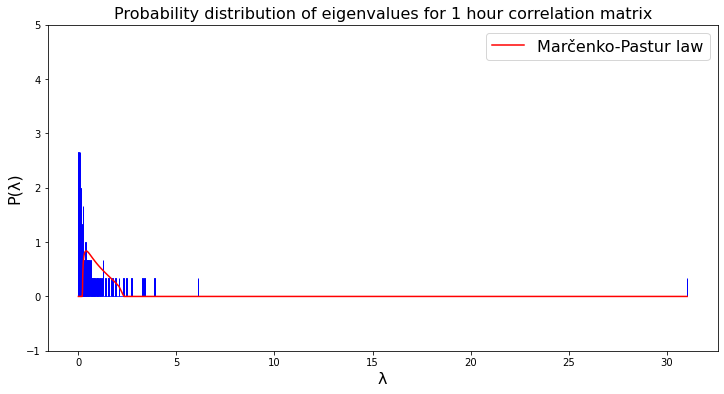

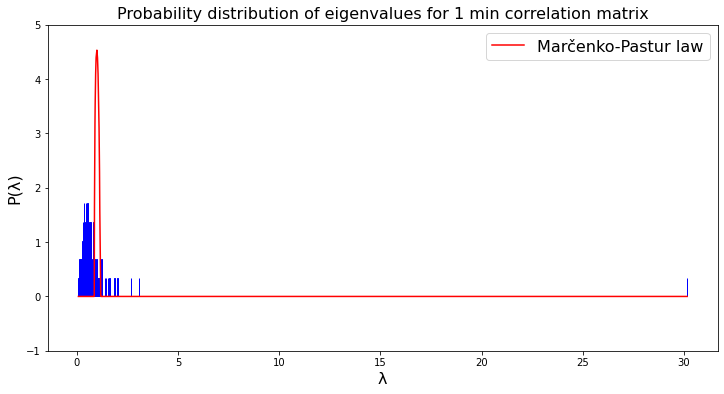

In [4]:

eigvec = [eigvec_h, eigvec_m] # list of eigenvectors of 1 hour and 1 min returns respectively
eigval = [eigval_h, eigval_m] # list of eigenvalues of 1 hour and 1 min returns respectively
eigval_max = [eigval_h_max, eigval_m_max] # list of max eigenvalue of 1 hour and 1 min returns
eigval_min = [eigval_h_min, eigval_m_min] # list of min eigenvalue of 1 hour and 1 min returns
Q = [Q_hour, Q_min] # list of given Q value of 1 hour and 1 min returns respectively
name = ['1 hour', '1 min']  # list of names to be used in plot labels and print statements
pList = [[],[]] # list to store MP law probabilities of eigenvalues of 1 hour and 1 min returns

# loop to calculate distribution (p) of the eigenvalues as per MP law
for i in range(2):

    for lam in sorted(eigval[i]):
        if (lam > eigval_max[i] or lam < eigval_min[i]):
            p = 0
        else:
            p = (Q[i]/(2*np.pi*(sigma**2)))*(np.sqrt((eigval_max[i] - lam)\
                                                  *(lam - eigval_min[i]))/lam)

        pList[i].append(p)   # pList: list for probability of eigenvalues
    
    # plot graphs of distribution of eigenvalues
    plt.figure(figsize = (12,6))

    plt.plot(sorted(eigval[i]), pList[i], label = 'Marčenko-Pastur law', color = 'red')

    # plot histogram of eigval_list[5]: array of sorted eigenvalues
    plt.hist(sorted(eigval[i]), density = True, bins = 1000, edgecolor = 'blue')
    plt.xlabel('λ', fontsize = 16)
    plt.ylabel('P(λ)', fontsize = 16)
    plt.title('Probability distribution of eigenvalues for ' + name[i] + 
              ' correlation matrix', fontsize = 16)
    plt.legend(fontsize = 16)
    plt.ylim(-1,5)
    print('\n')
    plt.show()
    print('\n')



### Below: Compute and plot 1 hour vs 1 minute denoised correlations<br>

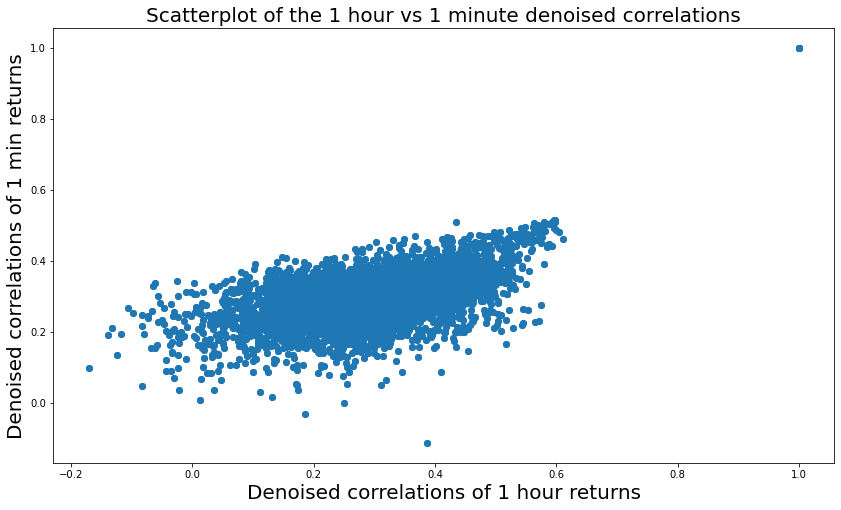

In [5]:

corList = []

for i in range(2): 
    
    # Filter out the noise eigenvalues (𝜆 < 𝜆𝑚𝑎𝑥 is classified as noise)
    # Replace noise 𝜆s with a constant c such that ∑𝜆 = 𝑁
    c = (len(eigval[i]) - sum(eigval[i][eigval[i] >= eigval_max[i]]))/(len(eigval[i][eigval[i] < eigval_max[i]]))

    eigval[i][eigval[i] < eigval_max[i]] = c

    # Undo diagonalisation to get the denoised correlation matrix: 𝑌 = 𝑉Λ(V**(-1))
    # where 𝑉 is the eigenvectors matrix and Λ is the diagonal matrix of eigenvalues
    Y =  np.dot(eigvec[i], np.dot(np.diag(eigval[i]), np.linalg.inv(eigvec[i])))

    # define the diagonal matrix of Y: 𝐷 such that 𝐷𝑖𝑖=1/√𝑌𝑖𝑖
    D = np.diagonal(Y)
    D = 1/np.sqrt(D)
    D = np.diag(D)
    
    # rescale to have unit diagonal by doing Y = DYD
    Y = np.dot(D, np.dot(Y,D))
    
    corList.append(Y)   # list of denoised correlation matrices of 1 hour and 1 min returns

print()
plt.figure(figsize = (14,8))
plt.scatter(corList[0], corList[1])
plt.title('Scatterplot of the 1 hour vs 1 minute denoised correlations', fontsize = 20)
plt.xlabel('Denoised correlations of 1 hour returns', fontsize = 20)
plt.ylabel('Denoised correlations of 1 min returns', fontsize = 20)
plt.show()
print()

### Below: Minimum Spanning Trees<br>

<ipython-input-6-f35cf7a9c3f2>:7: RuntimeWarning: invalid value encountered in sqrt
  d_h = np.sqrt(2*(1-corList[0])) # filtered correlation matrix for 1 hour
<ipython-input-6-f35cf7a9c3f2>:8: RuntimeWarning: invalid value encountered in sqrt
  d_m = np.sqrt(2*(1-corList[1])) # filtered correlation matrix for 1 min


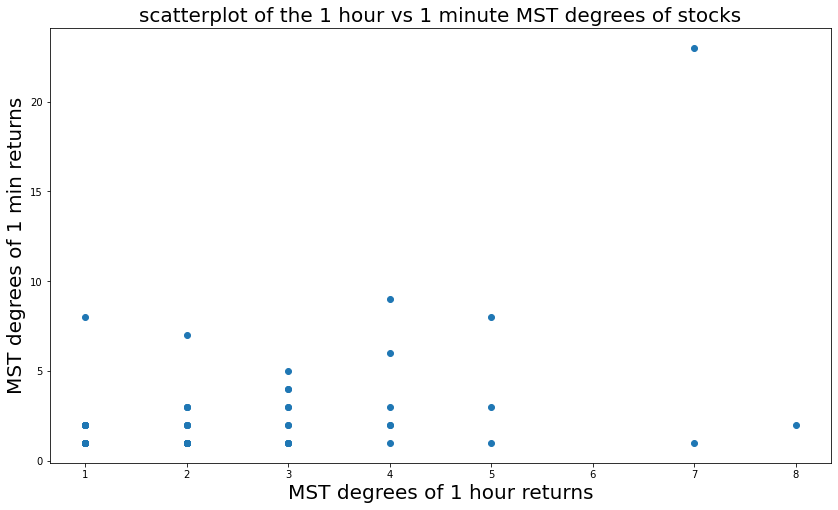

In [6]:
MSTgraphs = []

filtered_cormat = []                  # initialize list to add filtered correlation matrix of 1 hour and 1 min returns

# Filtering correlations by using them to define some metric distance as 𝑑𝑖𝑗 = √2(1 − 𝑟𝑖𝑗)

d_h = np.sqrt(2*(1-corList[0])) # filtered correlation matrix for 1 hour
d_m = np.sqrt(2*(1-corList[1])) # filtered correlation matrix for 1 min

filtered_cormat.append(np.nan_to_num(d_h))   # convert all Nan values to 0 and append filtered correlation matrix to list D
filtered_cormat.append(np.nan_to_num(d_m))   # convert all Nan values to 0 and append filtered correlation matrix to list D

file = open('Data/stocknames.txt')  # open text file with stock names
nodenames = {}
i = 0
for f in file:                      # for each stock ticker
    nodenames[i] = f.rstrip()       # dictionary of tickers corresponding to each node
    i += 1                          # counter for nodes

for g in filtered_cormat:
    G = nx.from_numpy_matrix(g)                  # create a graph from matrix D
    nx.set_node_attributes(G, nodenames, 'name') # assign the tickers as an attribute to the nodes
    G = nx.minimum_spanning_tree(G)              # Build minimum spanning tree   
    MSTgraphs.append(G)

file.close()

deg_h, deg_m = [], []
# list of MST degrees for 1 hour and 1 min returns respectively
for d in MSTgraphs[0].degree(): deg_h.append(d[1])
for d in MSTgraphs[1].degree(): deg_m.append(d[1])


# plot MST degrees of 1 min versus 1 hour returns
plt.figure(figsize = (14,8))
plt.scatter(deg_h, deg_m)
plt.title('scatterplot of the 1 hour vs 1 minute MST degrees of stocks', fontsize = 20)
plt.xlabel('MST degrees of 1 hour returns', fontsize = 20)
plt.ylabel('MST degrees of 1 min returns', fontsize = 20)
plt.show()


# Conclusions


### 1. Is there a ‘market mode’?
Yes. Market mode is the largest eigenvalue. Usually it is much larger than expected as per Marčenko-Pastur law. 

Market mode for 1 hour returns is 31.03 and for 1 min returns is 30.16 approximately.

In [7]:

print('Market mode of 1 hour returns: ', max(eigval_h))
print('Market mode of 1 min returns: ', max(eigval_m))


Market mode of 1 hour returns:  31.027835738491508
Market mode of 1 min returns:  30.159679989499097


### 2. Which is the stock that has the strongest relation with the market?



In [8]:
# a stock’s relation to the market mode is given by the corresponding element of the eigenvector of the 
# largest eigenvalue

for i in range(2):
    
    # filtered_cormat is the list of filtered correlation matrices for 1 hour and 1 min returns
    Eig_Val, Eig_Vec = np.linalg.eig(filtered_cormat[i])   
    strong_stock = nodenames[np.argmax(np.absolute(Eig_Vec[np.argmax(Eig_Val)]))]
    print('Stock that has the strongest relation with the market after', name[i],'returns: ',strong_stock)



Stock that has the strongest relation with the market after 1 hour returns:  CAT
Stock that has the strongest relation with the market after 1 min returns:  IBM


### 3. Which are the 5 stocks with highest degree on the MST?

In [9]:
for i in range(2):
    
    d = dict(MSTgraphs[i].degree())
    top_5_degree = sorted(d, key=d.get, reverse=True)[:5]
    print('\n')
    
    for key, val in d.items():
        if val == d[top_5_degree[4]]: # compare if other stocks have same degrees as lowest of top 5 degrees
            if key not in top_5_degree: top_5_degree.append(key)
        
    print('Stocks with five highest degree on MST of',  name[i], 'returns are:')
    
    # loop to print tickers with highest degrees
    for t in top_5_degree:
        print('Degree of', (nx.get_node_attributes(MSTgraphs[i], 'name'))[t] , ' : ' , MSTgraphs[i].degree()[t])
    



Stocks with five highest degree on MST of 1 hour returns are:
Degree of GOOG  :  8
Degree of HON  :  7
Degree of MMM  :  7
Degree of AXP  :  5
Degree of DIS  :  5
Degree of GS  :  5


Stocks with five highest degree on MST of 1 min returns are:
Degree of HON  :  23
Degree of MET  :  9
Degree of DIS  :  8
Degree of MRK  :  8
Degree of EMR  :  7


### 4. Is the degree distribution of MSTs qualitatively the same at 1 minute and 1 hour?

Most of the stocks have degrees within range of 5 after 1 hour returns and 1 min returns. There are few outliers which have higher degrees. We see there is a cluster of stocks with low degree values at the bottom left of the graph. Therefore qualitatively, the degree distribution of MSTs is similar at 1 min and 1 hour.


### Dhanyawaad!! (Thank you in Hindi language)